# Lab 7

- Daniel Rayo 22933
- Flavio Galán 22386
- Irving Acosta 22781
- Nombre carne

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

## Red Neuronal

Se utilizo una rede neuronal totalmente conectada de 3 capas de 128 neuronas cada una. El objetivo de la red es poder predecir los *"Quality values"* (tambien llamados *Q-values*) asociados a cada acción que se puede tomar dado un contexto/estado actual.

In [3]:
class DQN(nn.Module):
    """Deep Q-Network architecture."""

    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.network(x)

## Replay Buffer

El replay buffer es una cola (una lista con una capacidad máxima, cuando se consigue la cantidad máxima, el primer elemento es desechado para agregar otro) que guarda un historial de las acciones pasadas tomadas en las diferentes situaciones vividas junto con la recompensa obtenida.

Realmente la red neuronal no trabajara con los valores inmediatos dados por gymnasium, sino que usara el Replay Buffer como su dataset de entrada para poder entrenarse, esto permite a la red todavía iterar sobre ejemplos pasados, y evitar cometer los mismos errores.

In [4]:
class ReplayBuffer:
    """Experience replay buffer for storing and sampling experiences."""

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Add experience to buffer."""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        """Sample random batch of experiences."""
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

## Agente

In [5]:
class DQNAgent:
    """DQN Agent with online and target networks."""

    def __init__(
        self,
        env,
        learning_rate=0.001,
        initial_epsilon=1.0,
        epsilon_decay=0.995,
        final_epsilon=0.01,
        discount_factor=0.99,
        buffer_capacity=10000,
        batch_size=64,
        target_update_frequency=100,
        hidden_size=128
    ):
        """Initialize DQN agent.

        Args:
            env: Gymnasium environment
            learning_rate: Learning rate for optimizer
            initial_epsilon: Starting exploration rate
            epsilon_decay: Decay factor for epsilon per episode
            final_epsilon: Minimum exploration rate
            discount_factor: Discount factor for future rewards
            buffer_capacity: Size of experience replay buffer
            batch_size: Number of experiences to sample for training
            target_update_frequency: How often to update target network every 'n' episodes
            hidden_size: Size of hidden layers in neural networks
        """
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Get environment dimensions
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n

        # Create online and target networks
        self.online_network = DQN(self.state_size, hidden_size, self.action_size).to(self.device)
        self.target_network = DQN(self.state_size, hidden_size, self.action_size).to(self.device)

        # Initialize target network with same weights as online network
        self.target_network.load_state_dict(self.online_network.state_dict())
        self.target_network.eval()  # Target network is not trained directly

        # Optimizer and loss function for the online network
        self.optimizer = optim.Adam(self.online_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        # Hyperparameters
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.target_update_frequency = target_update_frequency

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Experience replay buffer
        self.replay_buffer = ReplayBuffer(buffer_capacity)

        # Training tracking
        self.episode_count = 0
        self.losses = []
        self.episode_rewards = []

    def get_action(self, state):
        """Choose action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            # Explore: random action
            return self.env.action_space.sample()
        else:
            # Exploit: best action according to online network
            with torch.no_grad():
                # Let the network predict the Q-values for the current state
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.online_network(state_tensor)
                # Choose the action with higher Q-value
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.replay_buffer.push(state, action, reward, next_state, done)

    def train_step(self):
        """Perform one training step using experience replay."""
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch from replay buffer
        batch = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        states = torch.FloatTensor([exp.state for exp in batch]).to(self.device)
        actions = torch.LongTensor([exp.action for exp in batch]).to(self.device)
        rewards = torch.FloatTensor([exp.reward for exp in batch]).to(self.device)
        next_states = torch.FloatTensor([exp.next_state for exp in batch]).to(self.device)
        dones = torch.BoolTensor([exp.done for exp in batch]).to(self.device)

        # Let online network choose the action with hightest Q-value
        # for each state of the batch.
        current_q_values = self.online_network(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            # Let target_network predict the q-values for each action in the next states.
            next_q_values = self.target_network(next_states).max(1)[0]
            # Use the predictions from the line above, to calculate the actual expected q-values
            # that the online-network should've predicted.
            # using Bellman equation
            target_q_values = rewards + (self.discount_factor * next_q_values * ~dones)

        # Compute loss and update online network
        loss = self.criterion(current_q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.losses.append(loss.item())

    def update_target_network(self):
        """Copy weights from online network to target network."""
        self.target_network.load_state_dict(self.online_network.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, n_episodes):
        """Train the agent for specified number of episodes."""
        print(f"Training DQN agent for {n_episodes} episodes...")

        for episode in tqdm(range(n_episodes), desc="Training"):
            state, _ = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                # Choose and take action
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # Store experience
                self.store_experience(state, action, reward, next_state, done)

                # Train the network
                self.train_step()

                episode_reward += reward
                state = next_state

            # Update target network periodically
            if episode % self.target_update_frequency == 0:
                self.update_target_network()

            # Decay exploration rate
            self.decay_epsilon()

            # Track progress (for plotting learning rate latter)
            self.episode_rewards.append(episode_reward)
            self.episode_count += 1

            # Print progress every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")

### Función de testeo

In [6]:
def test_agent(agent, env, num_episodes=100, render=False):
    """Test the trained agent."""
    print(f"\nTesting agent for {num_episodes} episodes...")

    # Disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0

    test_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        test_rewards.append(episode_reward)

    # Restore epsilon
    agent.epsilon = old_epsilon

    # Print results
    avg_reward = np.mean(test_rewards)
    std_reward = np.std(test_rewards)
    max_reward = np.max(test_rewards)

    print(f"Test Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Max Reward: {max_reward}")
    print(f"Success Rate (>195): {np.mean(np.array(test_rewards) > 195):.1%}")

    return test_rewards

In [7]:
def plot_training_progress(agent):
    """Plot training progress."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot episode rewards
    ax1.plot(agent.episode_rewards)
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    # Plot moving average of rewards
    if len(agent.episode_rewards) >= 100:
        moving_avg = np.convolve(agent.episode_rewards, np.ones(100)/100, mode='valid')
        ax1.plot(range(99, len(agent.episode_rewards)), moving_avg, color='red', label='100-episode average')
        ax1.legend()

    # Plot training losses
    if agent.losses:
        ax2.plot(agent.losses)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

### Entrenamiento del agente

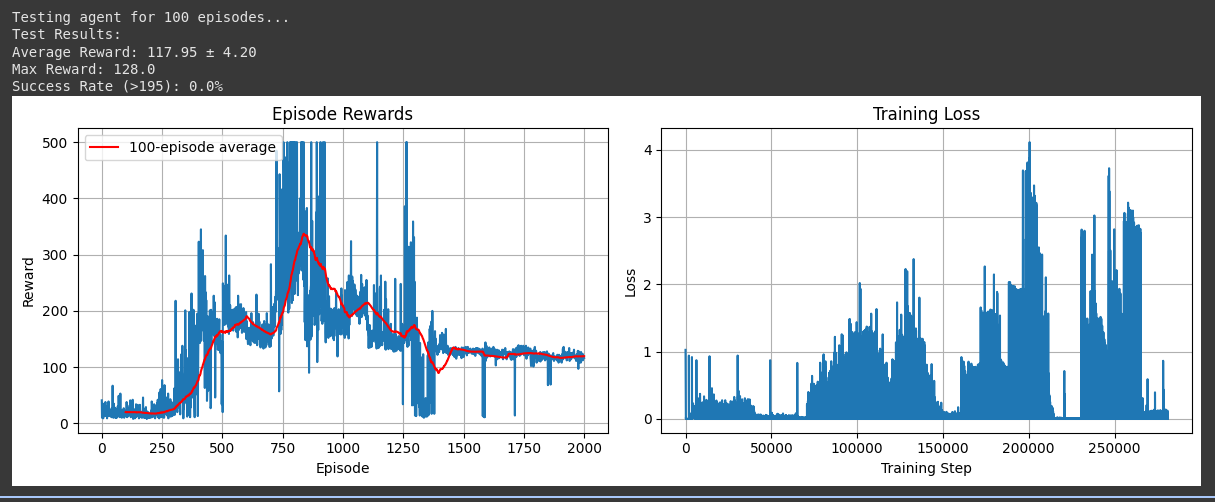

Al entrenar el agente se puede ver que tiene un rendimiento pésimo, llegando solamente el 30% (en la imagen se muestra 0% pero es porque se corrió varias veces) de las veces a superar la cantidad de 195 ticks de simulación. Puede ser que esto se deba a que estamos entrenando demasiado al modelo por lo que reduciremos el entrenamiento a la mitad, a tan solo mil épocas.

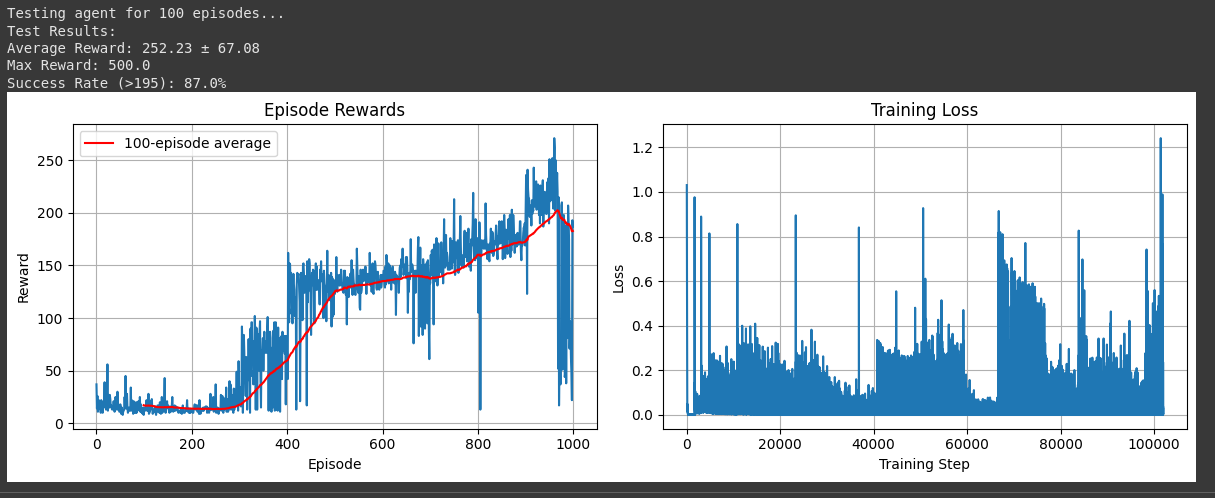

Con mil epocas tenemos un success rate mucho mejor, ya que se encuentra más cerca de 90% que de 80% de éxito. Si reducimos más el tiempo de entrenamiento tenemos:

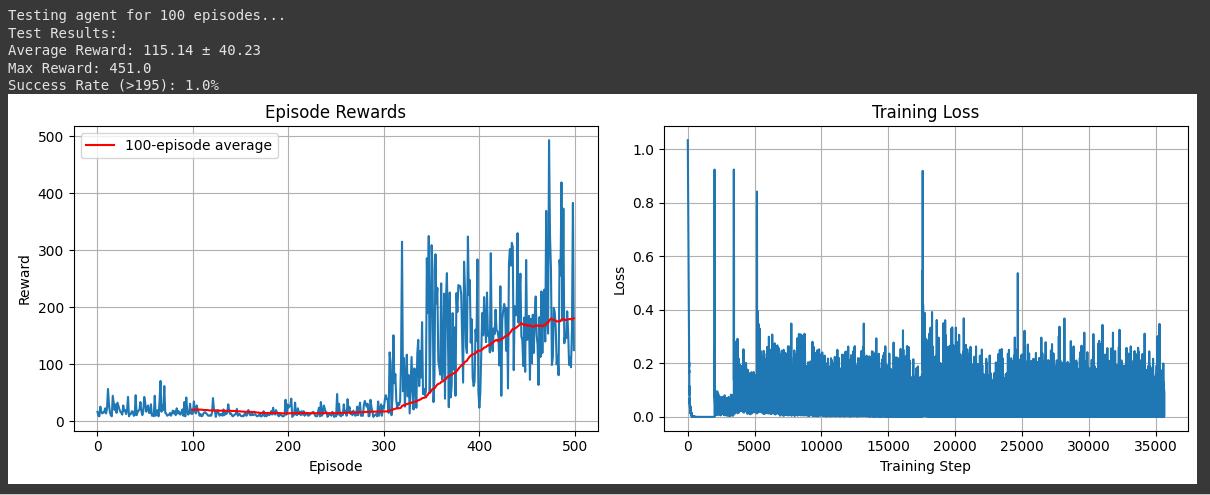
Aunque valía la pena el intento, no se repitió el éxito del entrenamiento anterior. Por lo que para mejorar el entrenamiento tendremos que mejorar algo más del agente. Intentemos regresar al agente a 1000 epocas pero ahora actualizaremos más seguido a la red neuronal target, cada 50 iteraciones:

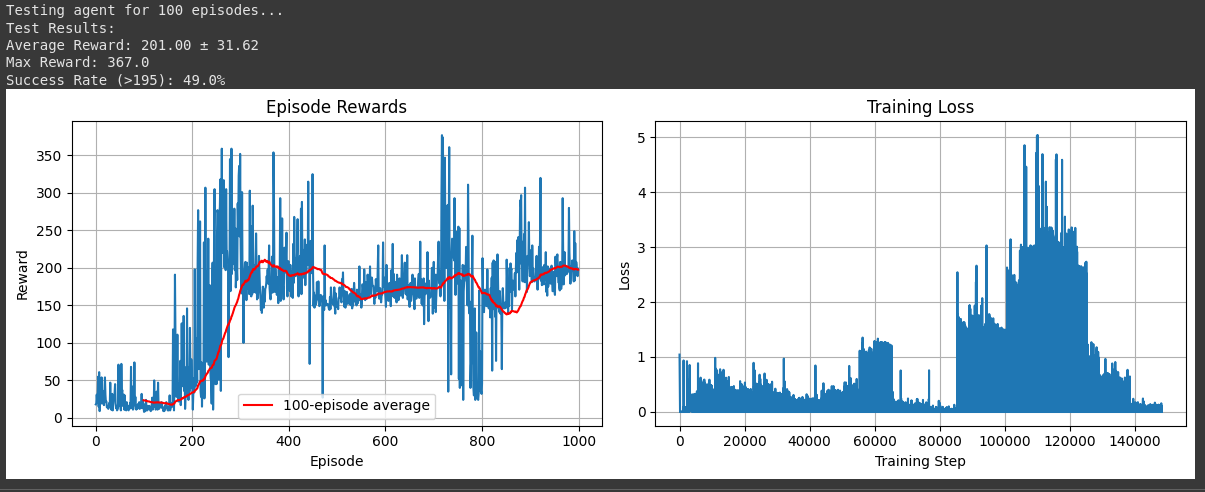

Lamentablemente este experimento tampoco resultó. Por lo que el mejor modelo hasta ahora es el de 1000 épocas con una actualización cada 100. Intentemos ahora actualizando cada 200.

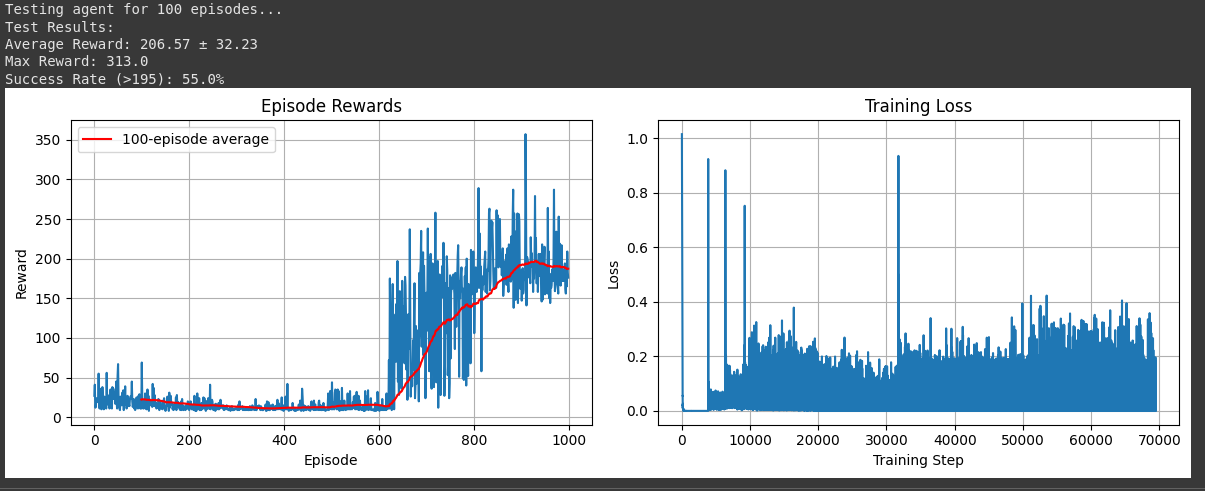

Aunque mejoró, sigue siendo peor que el mejor modelo hasta el momento. Por lo tanto, el modelo con 87% consideramos que es el mejor que se logró conseguir con la red básica, si mejoramos la red o cambiamos de arquitectura podremos obtener un resultado mejor.

In [ ]:
# Best agent configuration so far

# Create CartPole environment
env = gym.make('CartPole-v1')

# Create and train agent
agent = DQNAgent(
    env=env,
    learning_rate=0.0001,
    initial_epsilon=1.0,
    epsilon_decay=0.995,
    final_epsilon=0.01,
    discount_factor=0.99,
    buffer_capacity=10000,
    batch_size=64,
    target_update_frequency=100,
    hidden_size=128
)

# Train the agent
n_episodes = 1000
agent.train(n_episodes)

# Test the trained agent
test_rewards = test_agent(agent, env, num_episodes=100)

# Plot results
plot_training_progress(agent)

# Close environment
env.close()

### Demo del agente

In [12]:
def visualize_agent(agent, num_episodes=5):
    """Visualize the trained agent playing CartPole with graphical interface."""
    print(f"\nVisualizing agent for {num_episodes} episodes...")
    print("Close the window to stop visualization.")

    # Create environment with human rendering
    vis_env = gym.make('CartPole-v1', render_mode='human')

    # Disable exploration for visualization
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0

    try:
        for episode in range(num_episodes):
            state, _ = vis_env.reset()
            episode_reward = 0
            step_count = 0
            done = False

            print(f"\nEpisode {episode + 1}:")

            while not done:
                # Get action from trained agent
                action = agent.get_action(state)

                # Take action and render
                state, reward, terminated, truncated, _ = vis_env.step(action)
                done = terminated or truncated
                episode_reward += reward
                step_count += 1

                # Add small delay to make visualization watchable
                time.sleep(0.02)  # 50 FPS

            print(f"  Steps survived: {step_count}")
            print(f"  Total reward: {episode_reward}")

            # Pause between episodes
            if episode < num_episodes - 1:
                print("  Starting next episode in 2 seconds...")
                time.sleep(2)

    except KeyboardInterrupt:
        print("\nVisualization stopped by user.")

    finally:
        # Restore epsilon and close environment
        agent.epsilon = old_epsilon
        vis_env.close()

In [13]:
try:
    visualize_agent(agent, num_episodes=3)
except Exception as e:
    print(f"Visualization failed (this is normal in headless environments): {e}")
    print("To see visualization, run this on a system with display capabilities.")


Visualizing agent for 3 episodes...
Close the window to stop visualization.

Episode 1:
  Steps survived: 325
  Total reward: 325.0
  Starting next episode in 2 seconds...

Episode 2:
  Steps survived: 265
  Total reward: 265.0
  Starting next episode in 2 seconds...

Episode 3:
  Steps survived: 118
  Total reward: 118.0


## Análisis de experimentos (results.csv)

A continuación se cargan los resultados guardados en `results.csv`, se muestran estadísticas por experimento, y se generan gráficas comparativas:
- Barra: media de `mean_last20` por experimento.
- Boxplot: dispersión de `mean_last20` por experimento.
- Líneas: recompensas por episodio de cada corrida (si la columna `rewards` está presente).
Las figuras se guardan en `fig_mean_last20.png`, `fig_boxplot.png`, y `fig_rewards_runs.png`.


,mean_last20_mean,mean_last20_std,mean_last20_min,mean_last20_max,mean_all_mean,max_max
exp,,,,,,
1x256,98.083333,26.229865,72.15,124.60,40.364444,274.0
2x128,88.183333,29.733707,53.85,105.45,38.157778,266.0
2x64,99.316667,35.190280,58.80,122.25,50.664444,298.0
3x128,128.150000,13.976856,113.70,141.60,61.514444,328.0


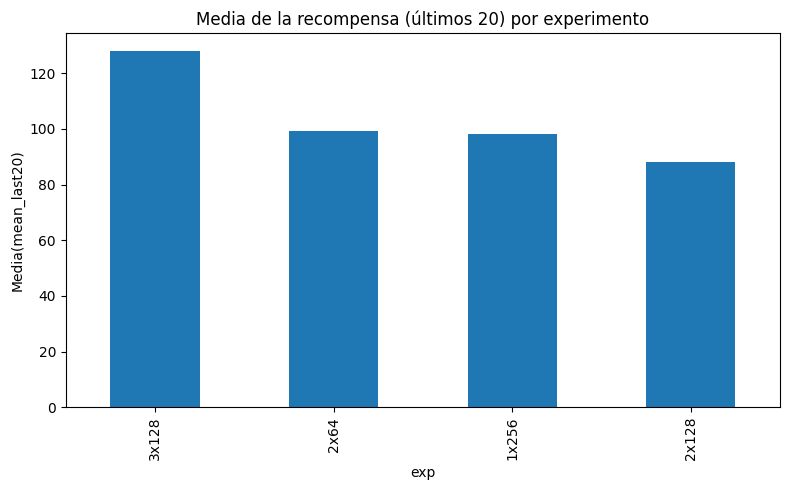

C:\Users\irvin\AppData\Local\Temp\ipykernel_7972\2295472755.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=labels, showmeans=True)


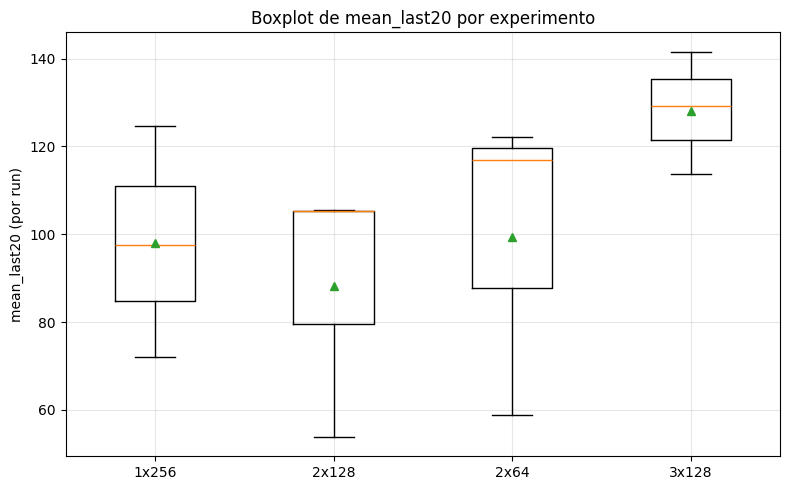

No se encontró columna 'rewards' con series. Solo hay estadísticas por run.
Resumen guardado en results_summary_by_exp.csv y figuras guardadas en fig_*.png


In [ ]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

csv_path = Path("results.csv")
if not csv_path.exists():
    raise FileNotFoundError(f"No encontré {csv_path.resolve()}. Asegura que el script guardó results.csv aquí.")

df = pd.read_csv(csv_path)

# Si la columna 'rewards' existe y es stringified list, parsearla
if 'rewards' in df.columns:
    def try_parse_rewards(x):
        try:
            return np.array(ast.literal_eval(x))
        except Exception:
            return None
    df['rewards_list'] = df['rewards'].apply(lambda x: try_parse_rewards(x) if pd.notna(x) else None)
else:
    df['rewards_list'] = None

# Estadísticas por experimento (mean of mean_last20, std, max)
summary = df.groupby("exp").agg({
    "mean_last20": ["mean", "std", "min", "max"],
    "mean_all": "mean",
    "max": "max"
})
summary.columns = ["_".join(col).strip() for col in summary.columns.values]
display(summary)

# Barra: media(mean_last20) por experimento
plt.figure(figsize=(8,5))
summary['mean_last20_mean'].sort_values(ascending=False).plot(kind='bar')
plt.ylabel("Media(mean_last20)")
plt.title("Media de la recompensa (últimos 20) por experimento")
plt.tight_layout()
plt.savefig("fig_mean_last20.png", dpi=150)
plt.show()

# Boxplot: dispersión entre runs de mean_last20
plt.figure(figsize=(8,5))
data_for_box = [group["mean_last20"].values for name, group in df.groupby("exp")]
labels = [name for name, _ in df.groupby("exp")]
plt.boxplot(data_for_box, labels=labels, showmeans=True)
plt.ylabel("mean_last20 (por run)")
plt.title("Boxplot de mean_last20 por experimento")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("fig_boxplot.png", dpi=150)
plt.show()

# Si hay rewards por run, graficar series (últimos N episodios por run)
if df['rewards_list'].notnull().any():
    plt.figure(figsize=(10,6))
    max_len = max((len(r) for r in df['rewards_list'].dropna()))
    # plot each run (ligeramente transparente)
    for idx, row in df.dropna(subset=['rewards_list']).iterrows():
        r = row['rewards_list']
        # suavizado simple (media móvil)
        window = 10
        if len(r) >= window:
            smooth = np.convolve(r, np.ones(window)/window, mode='valid')
            plt.plot(np.arange(len(smooth)), smooth, alpha=0.6, label=f"{row['exp']}-run{row['run']}")
        else:
            plt.plot(np.arange(len(r)), r, alpha=0.6, label=f"{row['exp']}-run{row['run']}")
    plt.xlabel("Episodio (suavizado)")
    plt.ylabel("Recompensa (media móvil)")
    plt.title("Recompensas por episodio — cada run (suavizado)")
    plt.legend(ncol=2, fontsize="small", loc="upper left")
    plt.tight_layout()
    plt.savefig("fig_rewards_runs.png", dpi=150)
    plt.show()
else:
    print("No se encontró columna 'rewards' con series. Solo hay estadísticas por run.")

# Guardar tabla resumida a CSV para la notebook/report
summary_out = summary.reset_index()
summary_out.to_csv("results_summary_by_exp.csv", index=False)
print("Resumen guardado en results_summary_by_exp.csv y figuras guardadas en fig_*.png")


En las gráficas la arquitectura 3x128 muestra la mayor media y mediana de mean_last20 pero con mayor dispersión (varianza alta y varios runs alcanzaron el tope), mientras que 2x128 queda por detrás con media más baja y menor variabilidad.

In [ ]:
# -------------------------
# Test estadístico
# -------------------------
import pandas as pd
from scipy import stats
df = pd.read_csv("results.csv")

a = df[df["exp"]=="3x128"]["mean_last20"].values
b = df[df["exp"]=="2x128"]["mean_last20"].values

print("N (3x128) =", len(a), "N (2x128) =", len(b))
print("Media (3x128) =", a.mean(), "std =", a.std(ddof=1))
print("Media (2x128) =", b.mean(), "std =", b.std(ddof=1))

# Test de normalidad rápido (Shapiro) para ver si t-test es adecuado (poca N son poco fiables)
print("\nShapiro normality p-values:")
print("3x128:", stats.shapiro(a).pvalue if len(a) >= 3 else "N<3")
print("2x128:", stats.shapiro(b).pvalue if len(b) >= 3 else "N<3")

t_res = stats.ttest_ind(a, b, equal_var=False)
mw_res = stats.mannwhitneyu(a, b, alternative='two-sided')

print("\nT-test (Welch): statistic=%.4f, p=%.4f" % (t_res.statistic, t_res.pvalue))
print("Mann-Whitney U: statistic=%.4f, p=%.4f" % (mw_res.statistic, mw_res.pvalue))

alpha = 0.05
if t_res.pvalue < alpha:
    print("\nResultado: diferencia SIGNIFICATIVA según t-test (p < 0.05).")
else:
    print("\nResultado: NO hay evidencia significativa según t-test (p >= 0.05).")


C:\Users\irvin\AppData\Local\Temp\ipykernel_7972\869985785.py:5: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy import stats


N (3x128) = 3 N (2x128) = 3
Media (3x128) = 128.15 std = 13.976855869615308
Media (2x128) = 88.18333333333334 std = 29.733707023062784

Shapiro normality p-values:
3x128: 0.8815866122499785
2x128: 0.00642322504910009

T-test (Welch): statistic=2.1070, p=0.1307
Mann-Whitney U: statistic=9.0000, p=0.1000

Resultado: NO hay evidencia significativa según t-test (p >= 0.05).


Con solo *3 repeticiones* por configuración la potencia estadística es muy baja: la media de `mean_last20` fue 128.15 (std 13.98) para *3x128* y 88.18 (std 29.73) para *2x128*. El *Shapiro* sugiere que `2x128` no sigue una distribución normal (p≈0.006), por lo que las asunciones del t-test se incumplen.

Los contrastes dan *p>0.05* (t-test p≈0.13; Mann–Whitney p≈0.10), por lo que *no hay evidencia estadística* para declarar una diferencia significativa con este tamaño de muestra. En lenguaje claro: los datos puntuales sugieren que 3x128 rinde mejor, pero con N=3 eso puede ser ruido — no es suficiente para concluirlo.


Entrenamiento final: 1000 episodios. Device: cpu. Guardado en: dqn_3x128_final.pth


Episodios:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\irvin\AppData\Local\Temp\ipykernel_7972\384244078.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  s = torch.FloatTensor([b.s for b in batch]).to(self.device)
Episodios:   1%|          | 6/1000 [00:00<00:17, 56.74it/s]

Ep    1 | recent_mean50: 18.00 | eps: 0.995 | replay_size: 18


Episodios:   5%|▌         | 52/1000 [00:04<01:24, 11.23it/s]

Ep   50 | recent_mean50: 21.02 | eps: 0.778 | replay_size: 1051


Episodios:  10%|█         | 102/1000 [00:07<00:56, 16.03it/s]

Ep  100 | recent_mean50: 19.44 | eps: 0.606 | replay_size: 2023


Episodios:  15%|█▌        | 151/1000 [00:12<01:48,  7.84it/s]

Ep  150 | recent_mean50: 35.54 | eps: 0.471 | replay_size: 3800


Episodios:  20%|██        | 201/1000 [00:24<02:45,  4.82it/s]

Ep  200 | recent_mean50: 83.22 | eps: 0.367 | replay_size: 7961


Episodios:  25%|██▌       | 250/1000 [00:39<03:55,  3.18it/s]

Ep  250 | recent_mean50: 108.40 | eps: 0.286 | replay_size: 13381


Episodios:  30%|███       | 300/1000 [01:02<05:11,  2.25it/s]

Ep  300 | recent_mean50: 160.80 | eps: 0.222 | replay_size: 20000


Episodios:  35%|███▌      | 350/1000 [01:32<05:59,  1.81it/s]

Ep  350 | recent_mean50: 210.72 | eps: 0.173 | replay_size: 20000


Episodios:  40%|████      | 400/1000 [02:00<05:37,  1.78it/s]

Ep  400 | recent_mean50: 200.82 | eps: 0.135 | replay_size: 20000


Episodios:  45%|████▌     | 450/1000 [04:06<34:07,  3.72s/it]

Ep  450 | recent_mean50: 181.44 | eps: 0.105 | replay_size: 20000


Episodios:  50%|█████     | 500/1000 [06:42<27:42,  3.33s/it]

Ep  500 | recent_mean50: 192.88 | eps: 0.082 | replay_size: 20000


Episodios:  55%|█████▌    | 550/1000 [07:08<03:41,  2.03it/s]

Ep  550 | recent_mean50: 180.56 | eps: 0.063 | replay_size: 20000


Episodios:  60%|██████    | 600/1000 [07:35<03:52,  1.72it/s]

Ep  600 | recent_mean50: 188.66 | eps: 0.049 | replay_size: 20000


Episodios:  65%|██████▌   | 650/1000 [10:25<27:01,  4.63s/it]

Ep  650 | recent_mean50: 201.00 | eps: 0.038 | replay_size: 20000


Episodios:  70%|███████   | 700/1000 [12:31<03:02,  1.64it/s]

Ep  700 | recent_mean50: 205.98 | eps: 0.030 | replay_size: 20000


Episodios:  75%|███████▌  | 750/1000 [12:59<02:13,  1.88it/s]

Ep  750 | recent_mean50: 184.12 | eps: 0.023 | replay_size: 20000


Episodios:  80%|████████  | 800/1000 [13:26<01:38,  2.04it/s]

Ep  800 | recent_mean50: 177.50 | eps: 0.018 | replay_size: 20000


Episodios:  85%|████████▌ | 850/1000 [13:49<01:22,  1.81it/s]

Ep  850 | recent_mean50: 157.84 | eps: 0.014 | replay_size: 20000


Episodios:  90%|█████████ | 900/1000 [14:11<00:50,  1.99it/s]

Ep  900 | recent_mean50: 146.08 | eps: 0.011 | replay_size: 20000


Episodios:  95%|█████████▌| 950/1000 [14:33<00:22,  2.18it/s]

Ep  950 | recent_mean50: 149.32 | eps: 0.010 | replay_size: 20000


Episodios: 100%|██████████| 1000/1000 [14:54<00:00,  1.12it/s]

Ep 1000 | recent_mean50: 142.48 | eps: 0.010 | replay_size: 20000
Modelo guardado en 'dqn_3x128_final.pth' (puedes cargarlo con torch.load)
Recompensas por episodio guardadas en 'training_rewards.csv'
Tiempo de entrenamiento aproximado: 14.90 minutos


Figura de entrenamiento guardada en 'training_rewards.png'


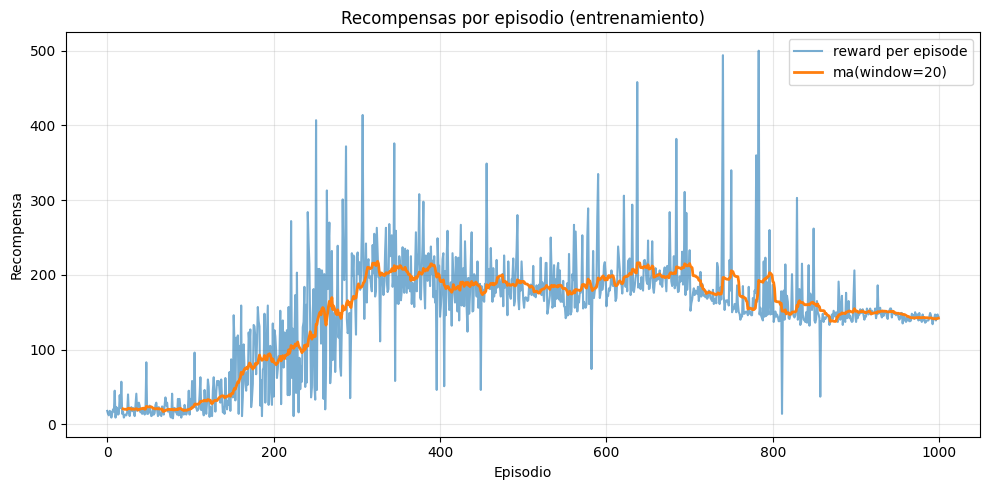

Evaluando modelo de forma determinística (eps=0.01)...
Evaluación (eps=0.01): mean=141.54, std=3.78 over 100 episodes
Evaluación guardada en 'evaluation_3x128.json'
Histograma de evaluación guardado en 'eval_rewards_hist.png'


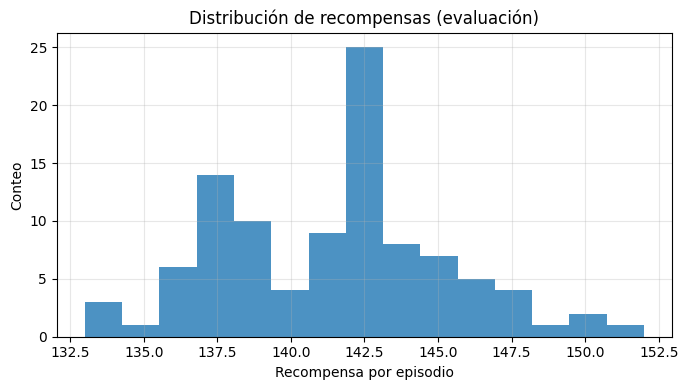


--- RESUMEN FINAL ---
Modelo: dqn_3x128_final.pth
Entrenamiento: 1000 episodios (guardados en training_rewards.csv)
Últimas 10 recompensas de entrenamiento: [146.0, 141.0, 134.0, 141.0, 143.0, 147.0, 139.0, 146.0, 147.0, 144.0]
Evaluación: mean=141.54, std=3.78 (n=100)
Figuras guardadas: training_rewards.png eval_rewards_hist.png
Evaluación JSON guardado en: evaluation_3x128.json


In [ ]:
# ==================================================
# - Arquitectura: 3x128
# ==================================================
import os, json, random, time
from collections import deque, namedtuple
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import gymnasium as gym
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import csv

# --------------------------
# Configuración
# --------------------------
ENV_NAME = "CartPole-v1"
HIDDEN_SIZES = [128, 128, 128]
LR = 1e-4
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_CAPACITY = 20000
TARGET_UPDATE = 50
N_EPISODES = 1000
MAX_STEPS = 500
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODEL_PATH = "dqn_3x128_final.pth"
EVAL_OUT_JSON = "evaluation_3x128.json"
TRAINING_PLOT = "training_rewards.png"
EVAL_HIST = "eval_rewards_hist.png"
TRAINING_CSV = "training_rewards.csv"

SEED = 12345
RANDOM_STATE_BASE = 1000

# --------------------------
# Reproducibilidad
# --------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# --------------------------
# Helpers: Experience, Buffer, Network, Agent
# --------------------------
Experience = namedtuple("Experience", ("s","a","r","s2","done"))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Experience(*args))
    def sample(self, n):
        return random.sample(self.buf, n)
    def __len__(self):
        return len(self.buf)

class DQNNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class Agent:
    def __init__(self, obs_dim, n_actions, hidden_sizes, device, lr=1e-3, gamma=0.99, batch_size=64, buffer_capacity=10000):
        self.device = device
        self.online = DQNNet(obs_dim, n_actions, hidden_sizes).to(device)
        self.target = DQNNet(obs_dim, n_actions, hidden_sizes).to(device)
        self.target.load_state_dict(self.online.state_dict())
        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.batch_size = batch_size
        self.replay = ReplayBuffer(buffer_capacity)
        self.n_actions = n_actions

    def act(self, state, eps):
        if random.random() < eps:
            return random.randrange(self.n_actions)
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q = self.online(s)
            return int(q.argmax(1).item())

    def update(self):
        if len(self.replay) < self.batch_size:
            return None
        batch = self.replay.sample(self.batch_size)
        s = torch.FloatTensor([b.s for b in batch]).to(self.device)
        a = torch.LongTensor([b.a for b in batch]).unsqueeze(1).to(self.device)
        r = torch.FloatTensor([b.r for b in batch]).to(self.device)
        s2 = torch.FloatTensor([b.s2 for b in batch]).to(self.device)
        done = torch.FloatTensor([0.0 if b.done else 1.0 for b in batch]).to(self.device)

        q_vals = self.online(s).gather(1, a).squeeze(1)
        with torch.no_grad():
            q_next = self.target(s2).max(1)[0]
            target_q = r + self.gamma * q_next * done
        loss = self.criterion(q_vals, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return float(loss.item())

    def sync_target(self):
        self.target.load_state_dict(self.online.state_dict())

# --------------------------
# Entrenamiento
# --------------------------
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

agent = Agent(obs_dim, n_actions, HIDDEN_SIZES, DEVICE, lr=LR, gamma=GAMMA, batch_size=BATCH_SIZE, buffer_capacity=BUFFER_CAPACITY)

eps = EPS_START
losses = []
rewards_all = []

print(f"Entrenamiento final: {N_EPISODES} episodios. Device: {DEVICE}. Guardado en: {SAVE_MODEL_PATH}")

start_time = time.time()
try:
    for ep in trange(1, N_EPISODES + 1, desc="Episodios", leave=True):
        # cada episodio con seed distinto para reproducibilidad controlada
        state, _ = env.reset(seed=RANDOM_STATE_BASE + ep + SEED)
        ep_reward = 0.0
        for t in range(MAX_STEPS):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.replay.push(state, action, reward, next_state, done)
            l = agent.update()
            if l is not None:
                losses.append(l)
            state = next_state
            ep_reward += reward
            if done:
                break
        rewards_all.append(ep_reward)
        eps = max(EPS_END, eps * EPS_DECAY)
        if ep % TARGET_UPDATE == 0:
            agent.sync_target()
        # status cada 50
        if ep % 50 == 0 or ep == 1:
            recent = np.mean(rewards_all[-50:]) if len(rewards_all) >= 1 else 0.0
            print(f"Ep {ep:4d} | recent_mean50: {recent:.2f} | eps: {eps:.3f} | replay_size: {len(agent.replay)}")
except KeyboardInterrupt:
    print("\nInterrupción detectada por el usuario. Guardando estado parcial...")

# Guardar modelo
torch.save(agent.online.state_dict(), SAVE_MODEL_PATH)
print(f"Modelo guardado en '{SAVE_MODEL_PATH}' (puedes cargarlo con torch.load)")

with open(TRAINING_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["episode", "reward"])
    for i, r in enumerate(rewards_all, 1):
        w.writerow([i, r])
print(f"Recompensas por episodio guardadas en '{TRAINING_CSV}'")

env.close()
train_time = time.time() - start_time
print(f"Tiempo de entrenamiento aproximado: {train_time/60:.2f} minutos")

# --------------------------
# Graficar recompensas de entrenamiento
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(rewards_all, alpha=0.6, label="reward per episode")
# media móvil
window = 20
if len(rewards_all) >= window:
    smooth = np.convolve(rewards_all, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, window-1+len(smooth)), smooth, color="tab:orange", linewidth=2, label=f"ma(window={window})")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Recompensas por episodio (entrenamiento)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(TRAINING_PLOT, dpi=150)
print(f"Figura de entrenamiento guardada en '{TRAINING_PLOT}'")
plt.show()

# --------------------------
# Evaluación determinística
# --------------------------
print("Evaluando modelo de forma determinística (eps=0.01)...")
eval_env = gym.make(ENV_NAME)
eval_agent = Agent(eval_env.observation_space.shape[0], eval_env.action_space.n, HIDDEN_SIZES, DEVICE, lr=LR, gamma=GAMMA, batch_size=BATCH_SIZE, buffer_capacity=BUFFER_CAPACITY)
eval_agent.online.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=DEVICE))
eval_agent.sync_target()

EVAL_EPISODES = 100
eval_rewards = []
for i in range(EVAL_EPISODES):
    s, _ = eval_env.reset(seed=RANDOM_STATE_BASE + 10000 + i + SEED)
    ep_r = 0.0
    done = False
    while not done:
        a = eval_agent.act(s, eps=0.01)
        s, r, term, trunc, _ = eval_env.step(a)
        done = term or trunc
        ep_r += r
    eval_rewards.append(ep_r)

eval_env.close()
eval_mean = float(np.mean(eval_rewards))
eval_std = float(np.std(eval_rewards))
print(f"Evaluación (eps=0.01): mean={eval_mean:.2f}, std={eval_std:.2f} over {EVAL_EPISODES} episodes")

# Guardar evaluación en JSON
out = {
    "env": ENV_NAME,
    "arch": HIDDEN_SIZES,
    "episodes_trained": N_EPISODES,
    "eval_episodes": EVAL_EPISODES,
    "eval_mean": eval_mean,
    "eval_std": eval_std,
    "eval_rewards": eval_rewards,
    "seed": SEED,
    "train_time_s": train_time
}
with open(EVAL_OUT_JSON, "w") as f:
    json.dump(out, f, indent=2)
print(f"Evaluación guardada en '{EVAL_OUT_JSON}'")

# --------------------------
# Histograma de evaluación
# --------------------------
plt.figure(figsize=(7,4))
plt.hist(eval_rewards, bins=15, alpha=0.8)
plt.xlabel("Recompensa por episodio")
plt.ylabel("Conteo")
plt.title("Distribución de recompensas (evaluación)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(EVAL_HIST, dpi=150)
print(f"Histograma de evaluación guardado en '{EVAL_HIST}'")
plt.show()

# --------------------------
# Resumen final
# --------------------------
print("\n--- RESUMEN FINAL ---")
print(f"Modelo: {SAVE_MODEL_PATH}")
print(f"Entrenamiento: {len(rewards_all)} episodios (guardados en {TRAINING_CSV})")
print(f"Últimas 10 recompensas de entrenamiento: {rewards_all[-10:] if len(rewards_all)>=10 else rewards_all}")
print(f"Evaluación: mean={eval_mean:.2f}, std={eval_std:.2f} (n={EVAL_EPISODES})")
print("Figuras guardadas:", TRAINING_PLOT, EVAL_HIST)
print("Evaluación JSON guardado en:", EVAL_OUT_JSON)


Durante el entrenamiento final de *1000 episodios con la arquitectura 3x128*, el agente mostró un progreso inicial marcado, alcanzando un promedio móvil de recompensas cercano a 200 alrededor del episodio 300–700. Sin embargo, en la fase final las recompensas comenzaron a decaer, estabilizándose en torno a los 140 puntos. La evaluación determinística sobre 100 episodios confirmó este comportamiento con una media de *141.5 ± 3.8* muy consistente pero por debajo del umbral clásico de 195 que define “resolver” CartPole. En conjunto, los resultados indican que la red logró aprender una política razonable y estable, pero aún limitada en su desempeño máximo; la caída posterior sugiere posibles problemas de sobreajuste inestabilidad del entrenamiento o necesidad de ajustes adicionales en hiperparámetros como la tasa de aprendizaje el esquema de exploración o la estrategia de actualización de la red objetivo.